# Analyzing Failure Cases of the Network <a class="tocSkip">

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-&amp;-Config" data-toc-modified-id="Imports-&amp;-Config-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports &amp; Config</a></span></li><li><span><a href="#Restore-Run-for-Analysis" data-toc-modified-id="Restore-Run-for-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Restore Run for Analysis</a></span></li><li><span><a href="#Establish-Test-Set-Accuracy" data-toc-modified-id="Establish-Test-Set-Accuracy-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Establish Test Set Accuracy</a></span></li><li><span><a href="#Analyze-Model-Predictions-on-Test-Set" data-toc-modified-id="Analyze-Model-Predictions-on-Test-Set-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Analyze Model Predictions on Test Set</a></span><ul class="toc-item"><li><span><a href="#Simple-Confusion-Matrix" data-toc-modified-id="Simple-Confusion-Matrix-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Simple Confusion Matrix</a></span></li><li><span><a href="#Fancy-Confusion-Matrix" data-toc-modified-id="Fancy-Confusion-Matrix-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Fancy Confusion Matrix</a></span></li></ul></li><li><span><a href="#Token-Distribution-on-Failure-Cases" data-toc-modified-id="Token-Distribution-on-Failure-Cases-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Token Distribution on Failure Cases</a></span><ul class="toc-item"><li><span><a href="#Failure-Cases" data-toc-modified-id="Failure-Cases-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Failure Cases</a></span></li><li><span><a href="#Good-Cases" data-toc-modified-id="Good-Cases-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Good Cases</a></span></li></ul></li></ul></div>

## Imports \& Config

In [1]:
# Set editor width to something sane
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import sys
# get root repository path
a = !pwd
repo_root = a[0].rsplit('ProGraML', maxsplit=1,)[0] + 'ProGraML'
print(repo_root)
#insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, repo_root)
repo_root = Path(repo_root)


/home/zacharias/ProGraML


In [3]:
import pickle

import numpy as np
from matplotlib import pyplot as plt
import tqdm
import torch
from torch_geometric.data import Data, DataLoader

In [4]:
from deeplearning.ml4pl.models.ggnn.ggnn_config_poj104 import GGNNConfig
from deeplearning.ml4pl.models.ggnn.run_ggnn_poj104 import Learner
from deeplearning.ml4pl.models.ggnn.ggnn_modules import GGNNModel
from deeplearning.ml4pl.poj104.dataset import POJ104Dataset


/home/zacharias/ProGraML/deeplearning/ml4pl/models/ggnn/run_ggnn_poj104.py
/home/zacharias/ProGraML


## Restore Run for Analysis

Set your custom `run_to_analyze` to something like `'2020-01-16-16-21-58_29971'` below!

In [5]:
# experiments to choose from
! ls -d -- classifyapp_logs/ault_logs_mirror/*/

classifyapp_logs/ault_logs_mirror/basic_run_full_subset_01-21_weird_testset/
classifyapp_logs/ault_logs_mirror/example_subfolder/
classifyapp_logs/ault_logs_mirror/large_run_full_subset/
classifyapp_logs/ault_logs_mirror/run_over_binary_choices/
classifyapp_logs/ault_logs_mirror/run_over_layer_timesteps/
classifyapp_logs/ault_logs_mirror/sub10_ts4x2_bs64/
classifyapp_logs/ault_logs_mirror/subset_degradation_baselines/


In [6]:
# set run to analyze
folder = Path('classifyapp_logs/ault_logs_mirror/run_over_binary_choices/')
run_to_analyze = '2020-01-23_01:35:52_poj004_24493'

In [7]:
!ls {folder} | grep {run_to_analyze}
print("")
!cat {folder}/{run_to_analyze}_params.json

2020-01-23_01:35:52_poj004_24493_log.json
2020-01-23_01:35:52_poj004_24493_model_best.pickle
2020-01-23_01:35:52_poj004_24493_params.json

{"backward_edges": true, "batch_size": 128, "clip_grad_norm": 0.0, "edge_type_count": 3, "edge_weight_dropout": 0.0, "emb_size": 200, "graph_state_dropout": 0.2, "has_aux_input": false, "has_graph_labels": true, "hidden_size": 200, "inst2vec_embeddings": "random", "layer_timesteps": [2, 2, 2, 2], "lr": 0.00025, "msg_mean_aggregation": true, "num_classes": 104, "num_epochs": 150, "output_dropout": 0.0, "patience": 100, "position_embeddings": true, "random_seed": 42, "selector_size": 0, "train_subset": [0, 100], "use_edge_bias": false, "use_node_types": false, "use_selector_embeddings": false, "vocab_size": 8568}

In [8]:
class Analyzer(object):
    """restore a model and analyze it deeply."""
    def __init__(self, args):
        # set default args and update
        self.args = {
            '--data_dir': 'deeplearning/ml4pl/poj104/classifyapp_data/',
            '--help': False,
            '--log_dir': 'deeplearning/ml4pl/poj104/classifyapp_logs/',
            '--restore': None,
            '--skip_restore_config': False,
            '--test': False,
        }
        self.args.update(args)
        print("initialized with:")
        print(self.args)

        if self.args.get('--restore', None) is not None:
            self.model = self.restore_model(path=repo_root / self.args['--restore'])
        else: # initialize fresh model
            self.global_training_step = 0
            self.current_epoch = 1
            test_only = self.args.get('--test', False)
            self.model = GGNNModel(self.config, test_only=test_only)
        
        # load data
        self.data_dir = repo_root / self.args.get('--data_dir', '.')
        self.valid_data = DataLoader(POJ104Dataset(root=self.data_dir, split='val'), batch_size=self.config.batch_size * 2, shuffle=False)
        self.test_data = DataLoader(POJ104Dataset(root=self.data_dir, split='test'), batch_size=self.config.batch_size * 2, shuffle=False)
        self.train_data = DataLoader(POJ104Dataset(root=self.data_dir, split='train', train_subset=[0,100]), batch_size=self.config.batch_size, shuffle=False)
        
        
    def restore_model(self, path):
        """loads and restores a model from file."""
        checkpoint = torch.load(path)
        self.run_id = checkpoint['run_id']
        self.global_training_step = checkpoint['global_training_step']
        self.current_epoch = checkpoint['epoch']

        config_dict = checkpoint['config'] if isinstance(checkpoint['config'], dict) else checkpoint['config'].to_dict()
        if not self.args.get('--skip_restore_config'):
            config = GGNNConfig.from_dict(config_dict)
            self.config = config
            print(f'*RESTORED* self.config from checkpoint {str(path)}.')
        else:
            print(f'Skipped restoring self.config from checkpoint!')
            self.config.check_equal(config_dict)
        
        test_only = self.args.get('--test', False)
        model = GGNNModel(self.config, test_only=test_only)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f'*RESTORED* model parameters from checkpoint {str(path)}.')
        if not self.args.get('--test', None):  # only restore opt if needed. opt should be None o/w.
            model.opt.load_state_dict(checkpoint['optimizer_state_dict'])
            print(f'*RESTORED* optimizer parameters from checkpoint as well.')
        return model

    def run_analysis_epoch(self, loader, epoch_type='eval'):
        """
        Runs a test epoch with detailed outputs.
        
        args:
            loader: a pytorch-geometric dataset loader,
            epoch_type: 'train' or 'eval'
        returns:
            loss, accuracy, instance_per_second
        """

        bar = tqdm.tqdm(total=len(loader) * loader.batch_size, smoothing=0.01, unit='inst')
        
        saved_outputs = []
        
        epoch_loss = 0
        accuracies = []
        start_time = time.time()
        processed_graphs = 0

        for step, batch in enumerate(loader):
            num_graphs = batch.batch[-1].item() + 1
            processed_graphs += num_graphs

            ######### prepare input
            # move batch to gpu and prepare input tensors:
            batch.to(self.model.dev)

            edge_lists = []
            edge_positions = [] if self.config.position_embeddings else None
            for i in range(3):
                # mask by edge type
                mask = batch.edge_attr[:, 0].squeeze() == i # <M_i>
                edge_list = batch.edge_index[:, mask].t()
                edge_lists.append(edge_list)
                
                if self.config.position_embeddings:
                    edge_pos = batch.edge_attr[mask, 1]
                    edge_positions.append(edge_pos)


            #############
            # RUN MODEL FORWARD PASS

            # enter correct mode of model
            if epoch_type == "train":
                self.global_training_step += 1

                if not self.model.training:
                    self.model.train()
                outputs = self.model(
                    vocab_ids=batch.x.squeeze(),
                    labels=batch.y - 1, # labels start at 0!!!
                    edge_lists=edge_lists,
                    pos_lists=edge_positions,
                    num_graphs=num_graphs,
                    graph_nodes_list=batch.batch,
                )
            else:  # not TRAIN
                if self.model.training:
                    self.model.eval()
                    self.model.opt.zero_grad()
                with torch.no_grad():  # don't trace computation graph!
                    outputs = self.model(
                        vocab_ids=batch.x.squeeze(),
                        labels=batch.y - 1,
                        edge_lists=edge_lists,
                        pos_lists=edge_positions,
                        num_graphs=num_graphs,
                        graph_nodes_list=batch.batch,
                    )
            
            saved_outputs.append(outputs)
            (
                logits,
                accuracy,
                logits,
                correct,
                targets,
                graph_features,
                *unroll_stats,
            ) = outputs

            loss = self.model.loss((logits, graph_features), targets)
            epoch_loss += loss.item() * num_graphs
            accuracies.append(np.array(accuracy.item()) * num_graphs)

            if epoch_type == "train":
                loss.backward()
                # TODO(github.com/ChrisCummins/ProGraML/issues/27):: Clip gradients
                # (done). NB, pytorch clips by norm of the gradient of the model, while
                # tf clips by norm of the grad of each tensor separately. Therefore we
                # change default from 1.0 to 6.0.
                # TODO(github.com/ChrisCummins/ProGraML/issues/27):: Anyway: Gradients
                # shouldn't really be clipped if not necessary?
                if self.model.config.clip_grad_norm > 0.0:
                    torch.nn.utils.clip_grad_norm_(
                        self.model.parameters(), self.model.config.clip_grad_norm
                    )
                self.model.opt.step()
                self.model.opt.zero_grad()

            bar.set_postfix(loss=epoch_loss / processed_graphs, acc=np.sum(accuracies, axis=0) / processed_graphs)
            bar.update(num_graphs)

        bar.close()
        mean_loss = epoch_loss / processed_graphs
        accuracy = np.sum(accuracies, axis=0) / processed_graphs
        instance_per_sec = processed_graphs / (time.time() - start_time)
        return mean_loss, accuracy, instance_per_sec
    
    def data2input(self, batch):
        num_graphs = batch.batch[-1].item() + 1

        ######### prepare input
        # move batch to gpu and prepare input tensors:
        batch.to(self.model.dev)

        edge_lists = []
        edge_positions = [] if self.config.position_embeddings else None
        for i in range(3):
            # mask by edge type
            mask = batch.edge_attr[:, 0].squeeze() == i # <M_i>
            edge_list = batch.edge_index[:, mask].t()
            edge_lists.append(edge_list)

            if self.config.position_embeddings:
                edge_pos = batch.edge_attr[mask, 1]
                edge_positions.append(edge_pos)
        inputs = {
            "vocab_ids": batch.x[:,0].squeeze(),
            "labels": batch.y - 1, # labels start at 0!!!
            "edge_lists": edge_lists,
            "pos_lists": edge_positions,
            "num_graphs": num_graphs,
            "graph_nodes_list": batch.batch,
        }
        return inputs

## Establish Test Set Accuracy

In [10]:
# run test epoch the standard way first to check performance and checkpoint compatibility
!pwd
!python ../models/ggnn/run_ggnn_poj104.py --restore deeplearning/ml4pl/poj104/{folder}/{run_to_analyze}_model_best.pickle \
 --test \
 --data_dir deeplearning/ml4pl/poj104/classifyapp_data/

/home/zacharias/ProGraML/deeplearning/ml4pl/models/ggnn/run_ggnn_poj104.py
/home/zacharias/ProGraML
/home/zacharias/ProGraML/deeplearning/ml4pl/poj104
/home/zacharias/ProGraML/deeplearning/ml4pl/models/ggnn/run_ggnn_poj104.py
/home/zacharias/ProGraML
{'--config': None,
 '--config_json': None,
 '--data_dir': 'deeplearning/ml4pl/poj104/classifyapp_data/',
 '--help': False,
 '--log_dir': 'deeplearning/ml4pl/poj104/classifyapp_logs/',
 '--restore': 'deeplearning/ml4pl/poj104/classifyapp_logs/ault_logs_mirror/run_over_binary_choices/2020-01-23_01:35:52_poj004_24493_model_best.pickle',
 '--restore_by_pattern': None,
 '--skip_restore_config': False,
 '--test': True}
*RESTORED* self.config from checkpoint /home/zacharias/ProGraML/deeplearning/ml4pl/poj104/classifyapp_logs/ault_logs_mirror/run_over_binary_choices/2020-01-23_01:35:52_poj004_24493_model_best.pickle.
Initializing with random embeddings
Moved model to cuda
*RESTORED* model parameters from checkpoint /home/zacharias/ProGraML/deeplea

In [11]:
args = {
    '--restore': str(Path('deeplearning/ml4pl/poj104') / folder / (run_to_analyze + '_model_best.pickle')),
    '--test': True,
}
analyzer = Analyzer(args=args)

initialized with:
{'--data_dir': 'deeplearning/ml4pl/poj104/classifyapp_data/', '--help': False, '--log_dir': 'deeplearning/ml4pl/poj104/classifyapp_logs/', '--restore': 'deeplearning/ml4pl/poj104/classifyapp_logs/ault_logs_mirror/run_over_binary_choices/2020-01-23_01:35:52_poj004_24493_model_best.pickle', '--skip_restore_config': False, '--test': True}
*RESTORED* self.config from checkpoint /home/zacharias/ProGraML/deeplearning/ml4pl/poj104/classifyapp_logs/ault_logs_mirror/run_over_binary_choices/2020-01-23_01:35:52_poj004_24493_model_best.pickle.
Initializing with random embeddings
Moved model to cuda
*RESTORED* model parameters from checkpoint /home/zacharias/ProGraML/deeplearning/ml4pl/poj104/classifyapp_logs/ault_logs_mirror/run_over_binary_choices/2020-01-23_01:35:52_poj004_24493_model_best.pickle.


## Analyze Model Predictions on Test Set 

In [12]:
analyzer.model.eval()
#logits_list, accuracy_list, correct_list, targets_list = [], [], [], []
targets_list = []
predicted_list = []
correct_list = []
for i, batch in enumerate(analyzer.test_data):

    inputs = analyzer.data2input(batch)
    with torch.no_grad():
        outputs = analyzer.model(**inputs)
    outputs = [o.clone().detach().cpu() for o in outputs]
    
    (
        logits,
        accuracy,
        _,
        correct,
        targets,
        _,
        *unroll_stats,
    ) = outputs
    
    predicted_list.append(logits.argmax(dim=1))
    targets_list.append(targets)
    correct_list.append(correct)
    
    #if i == 3:
    #    break

predicted = torch.cat(predicted_list)
targets = torch.cat(targets_list)
correct = torch.cat(correct_list)

In [13]:
# sanity check
assert torch.all((predicted == targets) == correct)

In [14]:
torch.mean(((predicted == targets).float()))

tensor(0.9612)

### Simple Confusion Matrix

In [15]:
import sklearn
cm = sklearn.metrics.confusion_matrix(targets, predicted)

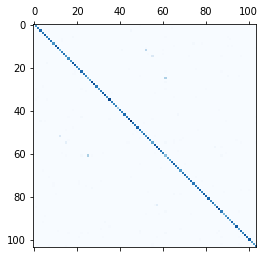

In [16]:
from matplotlib import pyplot as plt
plt.matshow(cm, cmap=plt.get_cmap('Blues'))

### Fancy Confusion Matrix

In [17]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8*4, 6*4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]) if cm[i,j]>0 else "",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

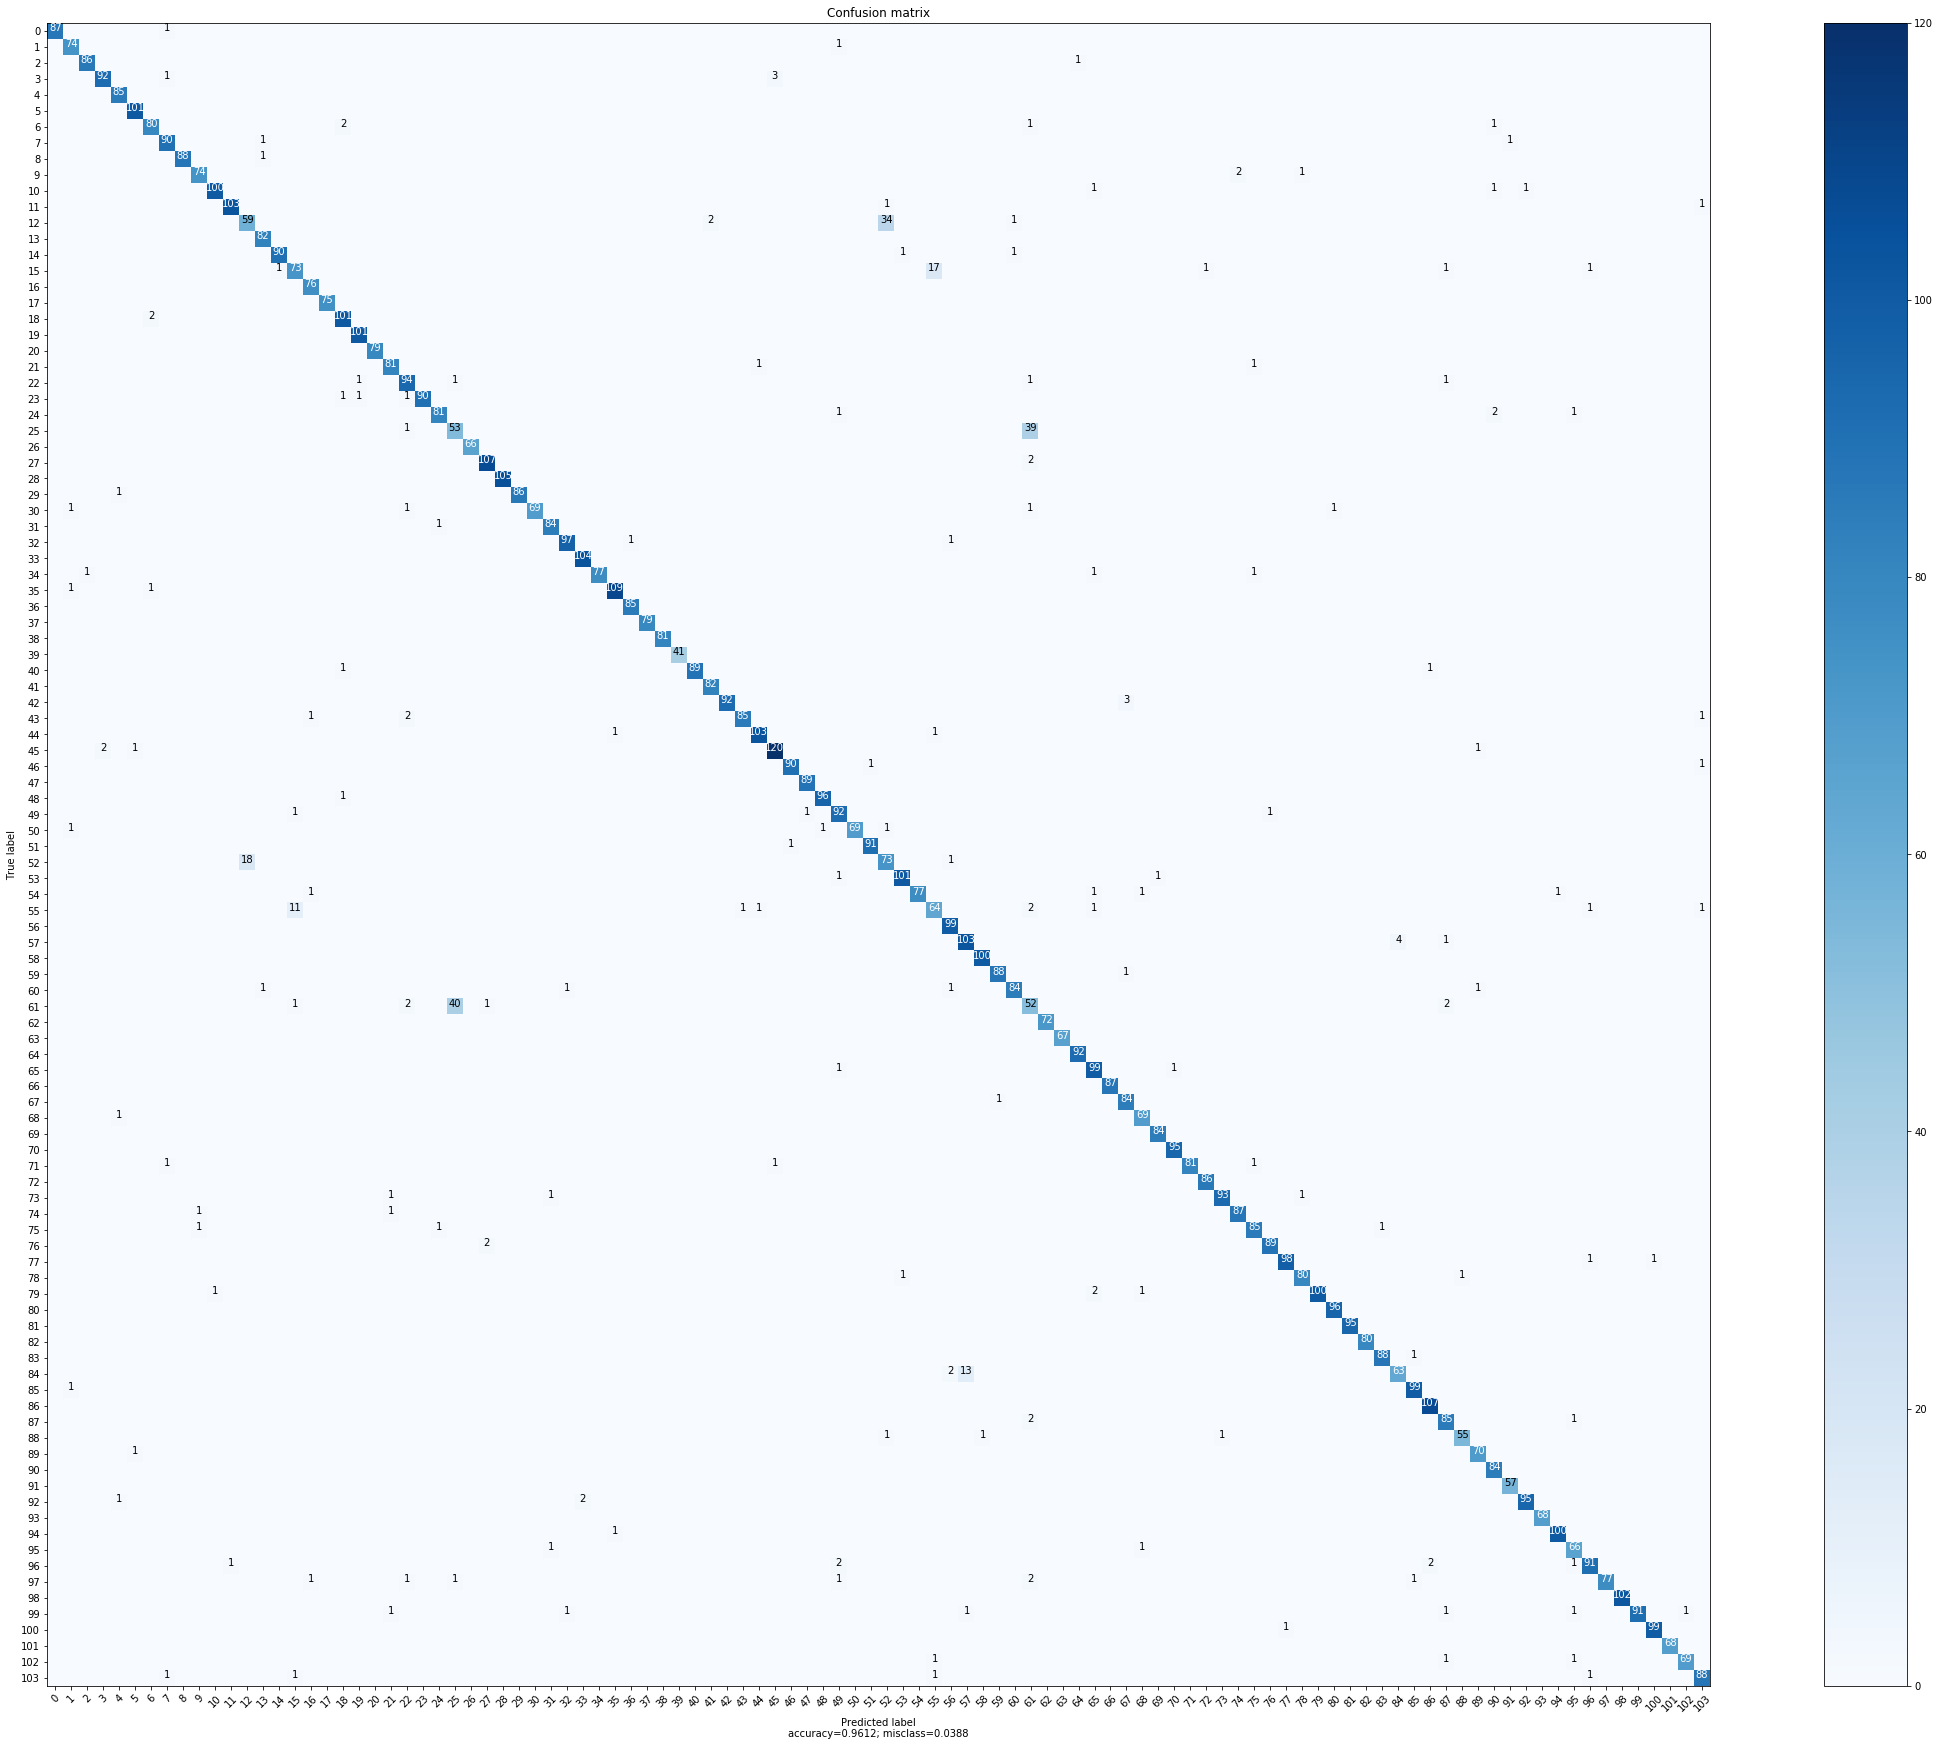

In [18]:
plot_confusion_matrix(cm, list(range(104)), normalize=False)

## Token Distribution on Failure Cases

### Failure Cases

In [19]:
failure_cases = []
good_cases = []
for i, data in enumerate(analyzer.test_data.dataset):
    if correct[i]:
        good_cases.append(data)
    else:
        failure_cases.append(data)

In [24]:
failure_bins = torch.zeros(8569,dtype=torch.long)
for data in failure_cases:
    bc = torch.bincount(data.x[:,0], minlength=8569)
    failure_bins += bc


In [25]:
failure_bins = failure_bins.numpy()

In [26]:
list(failure_bins[-10:])

[0, 0, 0, 0, 0, 17041, 46799, 0, 361, 0]

### Good Cases

In [27]:
good_bins = torch.zeros(8569,dtype=torch.long)
for data in good_cases:
    bc = torch.bincount(data.x[:,0], minlength=8569)
    good_bins += bc
good_bins = good_bins.numpy()

In [28]:
# how many bins are not zero?
print(sum(failure_bins > 0))
print(sum(good_bins > 0))

189
313


In [39]:
print('token, (failure count, good count)')
for i, cs in enumerate(zip(failure_bins, good_bins)):
    if cs[0] or cs[1]:
        #print(i, cs[0], cs[1])
        pass

token, (failure count, good count)


In [38]:
print('token, (count)')
for i, cs in enumerate(zip(failure_bins, good_bins)):
    if cs[0] or cs[1]:
        #print(i, cs[0] + cs[1])
        pass

token, (count)


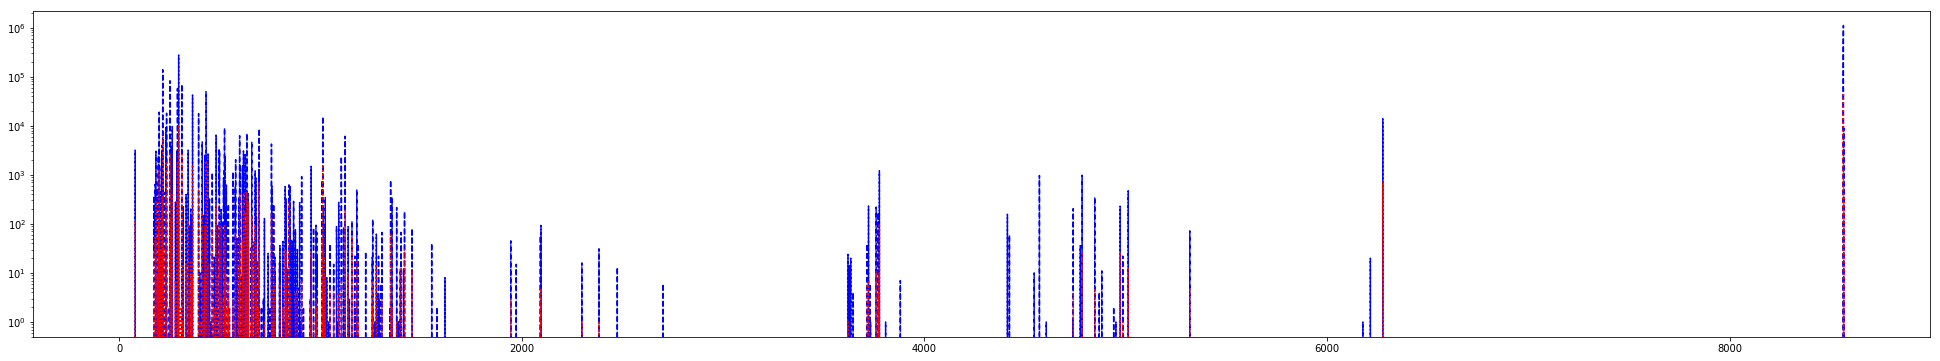

In [37]:

plt.figure(figsize=(34, 6))
plt.plot(good_bins, ls='--', c='blue')
plt.plot(failure_bins, ls='dotted', c='red')
plt.yscale('log')
plt.show()